# Template Variables Example

**Example: Using Template Variables with Pipeline**


Demonstrates how to use Jinja2-style template variables in SQL queries.
This is useful for:
- Multi-environment pipelines (dev, staging, prod)
- Parameterized table names
- dbt-style ref() functions
- Airflow macro substitution

### Imports

In [1]:
import yaml

from clgraph import Pipeline

# Example 1: Multi-Environment Pipeline
print("=" * 60)
print("Example 1: Multi-Environment Pipeline")
print("=" * 60)

# SQL with environment placeholders
queries_with_env = [
    """
    CREATE TABLE {{env}}_staging.orders AS
    SELECT
        order_id,
        customer_id,
        amount,
        order_date
    FROM raw.orders
    WHERE status = 'completed'
    """,
    """
    CREATE TABLE {{env}}_analytics.customer_metrics AS
    SELECT
        customer_id,
        COUNT(*) as order_count,
        SUM(amount) as total_revenue,
        AVG(amount) as avg_order_value
    FROM {{env}}_staging.orders
    GROUP BY customer_id
    """,
]

# Build pipeline for PRODUCTION environment
prod_pipeline = Pipeline.from_sql_list(
    queries_with_env, dialect="bigquery", template_context={"env": "prod"}
)

print("\nProduction Tables:")
for table in prod_pipeline.table_graph.tables.keys():
    print(f"  - {table}")

# Build pipeline for DEVELOPMENT environment
dev_pipeline = Pipeline.from_sql_list(
    queries_with_env, dialect="bigquery", template_context={"env": "dev"}
)

print("\nDevelopment Tables:")
for table in dev_pipeline.table_graph.tables.keys():
    print(f"  - {table}")

# Example 2: Project-Based Configuration
print("\n" + "=" * 60)
print("Example 2: Project-Based Configuration")
print("=" * 60)

queries_with_project = {
    "staging": """
        CREATE TABLE {{project}}.staging.user_data AS
        SELECT
            user_id,
            username,
            email,
            created_at
        FROM {{project}}.raw.users
    """,
    "analytics": """
        CREATE TABLE {{project}}.analytics.user_summary AS
        SELECT
            user_id,
            username,
            COUNT(*) as activity_count
        FROM {{project}}.staging.user_data
        JOIN {{project}}.raw.activities USING (user_id)
        GROUP BY user_id, username
    """,
}

pipeline = Pipeline.from_dict(
    queries_with_project, dialect="bigquery", template_context={"project": "my_company"}
)

print("\nGenerated Tables:")
for table in pipeline.table_graph.tables.keys():
    print(f"  - {table}")

# Example 3: Nested Variables
print("\n" + "=" * 60)
print("Example 3: Nested Variables (config.property)")
print("=" * 60)

queries_nested = [
    """
    CREATE TABLE {{config.project}}.{{config.env}}_staging.orders AS
    SELECT
        order_id,
        customer_id,
        amount
    FROM {{config.source_db}}.raw_{{config.region}}.orders
    WHERE created_at >= '{{config.start_date}}'
    """
]

pipeline_nested = Pipeline.from_sql_list(
    queries_nested,
    dialect="bigquery",
    template_context={
        "config": {
            "project": "data_platform",
            "env": "staging",
            "source_db": "external_db",
            "region": "us_central",
            "start_date": "2025-01-01",
        }
    },
)

print("\nGenerated Tables:")
for table in pipeline_nested.table_graph.tables.keys():
    print(f"  - {table}")

# Example 4: YAML Configuration (as you'd use in CLI)
print("\n" + "=" * 60)
print("Example 4: YAML-style Configuration")
print("=" * 60)

# YAML config file content
yaml_config = """
env: production
project: analytics_pipeline
config:
  region: us-central1
  dataset: customer_data
  start_date: 2025-01-01
"""

# Parse YAML
template_context = yaml.safe_load(yaml_config)

queries_yaml = [
    """
    CREATE TABLE {{project}}.{{env}}_staging.customers AS
    SELECT
        customer_id,
        customer_name,
        region
    FROM source.customers
    WHERE region = '{{config.region}}'
    AND created_at >= '{{config.start_date}}'
    """
]

pipeline_yaml = Pipeline.from_sql_list(
    queries_yaml, dialect="bigquery", template_context=template_context
)

print("\nYAML Config:")
print(yaml.dump(template_context, default_flow_style=False))

print("Generated Tables:")
for table in pipeline_yaml.table_graph.tables.keys():
    print(f"  - {table}")

# Example 5: Column Lineage with Templates
print("\n" + "=" * 60)
print("Example 5: Column Lineage Tracing with Templates")
print("=" * 60)

# Use the production pipeline from Example 1
print("\nTracing column lineage for: prod_analytics.customer_metrics.total_revenue")

# Trace column backward to sources
sources = prod_pipeline.trace_column_backward("prod_analytics.customer_metrics", "total_revenue")

print(f"\nSource columns ({len(sources)}):")
for source in sources:
    print(f"  - {source.table_name}.{source.column_name} ({source.node_type})")

# Example 6: Without Template Context (preserves template syntax)
print("\n" + "=" * 60)
print("Example 6: Without Template Context (SQL validation only)")
print("=" * 60)

pipeline_no_context = Pipeline.from_sql_list(
    queries_with_env,
    dialect="bigquery",
    # NO template_context provided
)

print("\nTables (template syntax preserved):")
for table in pipeline_no_context.table_graph.tables.keys():
    print(f"  - {table}")

print("\nNote: Template syntax like {{env}} is preserved when no template_context is provided.")
print("This is useful for SQL validation before deployment.")

# Example 7: dbt-style ref() functions
print("\n" + "=" * 60)
print("Example 7: dbt-style ref() Functions")
print("=" * 60)

dbt_queries = [
    """
    CREATE TABLE {{ ref('staging_orders') }} AS
    SELECT
        order_id,
        customer_id,
        amount
    FROM {{ ref('raw_orders') }}
    """
]


# Custom function to resolve dbt ref()
def resolve_dbt_ref(table_name):
    return f"my_project.{table_name}"


# Manually resolve refs (for demonstration)
# In practice, you'd use dbt's built-in templating
pipeline_dbt = Pipeline.from_sql_list(
    dbt_queries,
    dialect="bigquery",
    template_context={
        "ref": lambda name: f"my_project.{name}"  # Note: This won't work with Jinja2, just for demo
    },
)

print("\nNote: For full dbt integration, use dbt's compiled SQL output")
print("or implement a custom Jinja2 function resolver.")

print("\n" + "=" * 60)
print("Summary: Template Variables are Powerful!")
print("=" * 60)
print("""
✅ Use Cases:
  - Multi-environment deployments (dev/staging/prod)
  - Parameterized table names across regions/projects
  - dbt integration (via compiled SQL)
  - Airflow macro substitution
  - CI/CD pipeline configuration

✅ Supported Syntaxes:
  - Jinja2: {{ variable }}
  - Nested: {{ config.property }}
  - Functions: {{ ref('table') }} (with custom resolution)

✅ Input Formats:
  - Python dict: {"env": "prod"}
  - YAML: env: prod
  - JSON: {"env": "prod"}

💡 Best Practice:
  - Define template variables in separate config files (YAML/JSON)
  - Use consistent naming conventions (env, project, region)
  - Document required variables in README
  - Validate templates without context for syntax checking
""")

Query 'analytics': [unqualified_column] Unqualified column 'user_id' in expression for 'user_id'. With multiple tables (user_data, activities), the source table is ambiguous.


Query 'analytics': [unqualified_column] Unqualified column 'username' in expression for 'username'. With multiple tables (user_data, activities), the source table is ambiguous.


Example 1: Multi-Environment Pipeline

Production Tables:
  - prod_staging.orders
  - raw.orders
  - prod_analytics.customer_metrics

Development Tables:
  - dev_staging.orders
  - raw.orders
  - dev_analytics.customer_metrics

Example 2: Project-Based Configuration

Generated Tables:
  - my_company.staging.user_data
  - my_company.raw.users
  - my_company.analytics.user_summary
  - my_company.raw.activities

Example 3: Nested Variables (config.property)

Generated Tables:
  - data_platform.staging_staging.orders
  - external_db.raw_us_central.orders

Example 4: YAML-style Configuration

YAML Config:
config:
  dataset: customer_data
  region: us-central1
  start_date: 2025-01-01
env: production
project: analytics_pipeline

Generated Tables:
  - analytics_pipeline.production_staging.customers
  - source.customers

Example 5: Column Lineage Tracing with Templates

Tracing column lineage for: prod_analytics.customer_metrics.total_revenue

Source columns (1):
  - raw.orders.amount (base_co

### Code

In [2]:
import yaml

from clgraph import Pipeline

### Example 1: Multi-Environment Pipeline

In [3]:
print("Example 1: Multi-Environment Pipeline")

# SQL with environment placeholders
queries_with_env = [
    """
    CREATE TABLE {{env}}_staging.orders AS
    SELECT
        order_id,
        customer_id,
        amount,
        order_date
    FROM raw.orders
    WHERE status = 'completed'
    """,
    """
    CREATE TABLE {{env}}_analytics.customer_metrics AS
    SELECT
        customer_id,
        COUNT(*) as order_count,
        SUM(amount) as total_revenue,
        AVG(amount) as avg_order_value
    FROM {{env}}_staging.orders
    GROUP BY customer_id
    """,
]

# Build pipeline for PRODUCTION environment
prod_pipeline = Pipeline.from_sql_list(
    queries_with_env, dialect="bigquery", template_context={"env": "prod"}
)

print("\nProduction Tables:")
for table in prod_pipeline.table_graph.tables.keys():
    print(f"  - {table}")

# Build pipeline for DEVELOPMENT environment
dev_pipeline = Pipeline.from_sql_list(
    queries_with_env, dialect="bigquery", template_context={"env": "dev"}
)

print("\nDevelopment Tables:")
for table in dev_pipeline.table_graph.tables.keys():
    print(f"  - {table}")

Example 1: Multi-Environment Pipeline

Production Tables:
  - prod_staging.orders
  - raw.orders
  - prod_analytics.customer_metrics

Development Tables:
  - dev_staging.orders
  - raw.orders
  - dev_analytics.customer_metrics


### Example 2: Project-Based Configuration

In [4]:
print("Example 2: Project-Based Configuration")

queries_with_project = {
    "staging": """
        CREATE TABLE {{project}}.staging.user_data AS
        SELECT
            user_id,
            username,
            email,
            created_at
        FROM {{project}}.raw.users
    """,
    "analytics": """
        CREATE TABLE {{project}}.analytics.user_summary AS
        SELECT
            user_id,
            username,
            COUNT(*) as activity_count
        FROM {{project}}.staging.user_data
        JOIN {{project}}.raw.activities USING (user_id)
        GROUP BY user_id, username
    """,
}

pipeline = Pipeline.from_dict(
    queries_with_project, dialect="bigquery", template_context={"project": "my_company"}
)

print("\nGenerated Tables:")
for table in pipeline.table_graph.tables.keys():
    print(f"  - {table}")

Query 'analytics': [unqualified_column] Unqualified column 'user_id' in expression for 'user_id'. With multiple tables (user_data, activities), the source table is ambiguous.


Query 'analytics': [unqualified_column] Unqualified column 'username' in expression for 'username'. With multiple tables (user_data, activities), the source table is ambiguous.


Example 2: Project-Based Configuration

Generated Tables:
  - my_company.staging.user_data
  - my_company.raw.users
  - my_company.analytics.user_summary
  - my_company.raw.activities


### Example 3: Nested Variables

In [5]:
print("Example 3: Nested Variables (config.property)")

queries_nested = [
    """
    CREATE TABLE {{config.project}}.{{config.env}}_staging.orders AS
    SELECT
        order_id,
        customer_id,
        amount
    FROM {{config.source_db}}.raw_{{config.region}}.orders
    WHERE created_at >= '{{config.start_date}}'
    """
]

pipeline_nested = Pipeline.from_sql_list(
    queries_nested,
    dialect="bigquery",
    template_context={
        "config": {
            "project": "data_platform",
            "env": "staging",
            "source_db": "external_db",
            "region": "us_central",
            "start_date": "2025-01-01",
        }
    },
)

print("\nGenerated Tables:")
for table in pipeline_nested.table_graph.tables.keys():
    print(f"  - {table}")

Example 3: Nested Variables (config.property)

Generated Tables:
  - data_platform.staging_staging.orders
  - external_db.raw_us_central.orders


### Example 4: YAML Configuration (as you'd use in CLI)

In [6]:
print("Example 4: YAML-style Configuration")

# YAML config file content
yaml_config = """
env: production
project: analytics_pipeline
config:
  region: us-central1
  dataset: customer_data
  start_date: 2025-01-01
"""

# Parse YAML
template_context = yaml.safe_load(yaml_config)

queries_yaml = [
    """
    CREATE TABLE {{project}}.{{env}}_staging.customers AS
    SELECT
        customer_id,
        customer_name,
        region
    FROM source.customers
    WHERE region = '{{config.region}}'
    AND created_at >= '{{config.start_date}}'
    """
]

pipeline_yaml = Pipeline.from_sql_list(
    queries_yaml, dialect="bigquery", template_context=template_context
)

print("\nYAML Config:")
print(yaml.dump(template_context, default_flow_style=False))

print("Generated Tables:")
for table in pipeline_yaml.table_graph.tables.keys():
    print(f"  - {table}")

Example 4: YAML-style Configuration

YAML Config:
config:
  dataset: customer_data
  region: us-central1
  start_date: 2025-01-01
env: production
project: analytics_pipeline

Generated Tables:
  - analytics_pipeline.production_staging.customers
  - source.customers


### Example 5: Column Lineage with Templates

In [7]:
print("Example 5: Column Lineage Tracing with Templates")

# Use the production pipeline from Example 1
print("\nTracing column lineage for: prod_analytics.customer_metrics.total_revenue")

# Trace column backward to sources
sources = prod_pipeline.trace_column_backward("prod_analytics.customer_metrics", "total_revenue")

print(f"\nSource columns ({len(sources)}):")
for source in sources:
    print(f"  - {source.table_name}.{source.column_name} ({source.node_type})")

Example 5: Column Lineage Tracing with Templates

Tracing column lineage for: prod_analytics.customer_metrics.total_revenue

Source columns (1):
  - raw.orders.amount (base_column)


Production Pipeline Column Lineage:


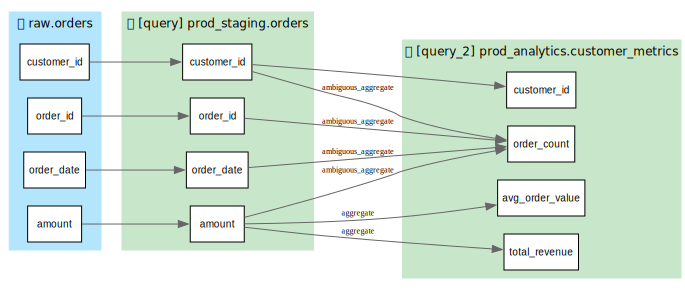

In [8]:
import shutil

from clgraph import visualize_pipeline_lineage

# Visualize the production pipeline lineage
if shutil.which("dot") is None:
    print("⚠️  Graphviz not installed. Install with: brew install graphviz")
    print("   Skipping visualization...")
else:
    print("Production Pipeline Column Lineage:")
    display(visualize_pipeline_lineage(prod_pipeline))

### Example 6: Without Template Context (preserves template syntax)

In [9]:
print("Example 6: Without Template Context (SQL validation only)")

pipeline_no_context = Pipeline.from_sql_list(
    queries_with_env,
    dialect="bigquery",
    # NO template_context provided
)

print("\nTables (template syntax preserved):")
for table in pipeline_no_context.table_graph.tables.keys():
    print(f"  - {table}")

print("\nNote: Template syntax like {{env}} is preserved when no template_context is provided.")
print("This is useful for SQL validation before deployment.")

Example 6: Without Template Context (SQL validation only)

Tables (template syntax preserved):
  - {{env}}_staging.orders
  - raw.orders
  - {{env}}_analytics.customer_metrics

Note: Template syntax like {{env}} is preserved when no template_context is provided.
This is useful for SQL validation before deployment.


### Example 7: dbt-style ref() functions

In [10]:
print("Example 7: dbt-style ref() Functions")

dbt_queries = [
    """
    CREATE TABLE {{ ref('staging_orders') }} AS
    SELECT
        order_id,
        customer_id,
        amount
    FROM {{ ref('raw_orders') }}
    """
]


# Note: resolve_dbt_ref is already defined in a previous cell
# Manually resolve refs (for demonstration)
# In practice, you'd use dbt's built-in templating
pipeline_dbt = Pipeline.from_sql_list(
    dbt_queries,
    dialect="bigquery",
    template_context={
        "ref": lambda name: f"my_project.{name}"  # Note: This won't work with Jinja2, just for demo
    },
)

print("\nNote: For full dbt integration, use dbt's compiled SQL output")
print("or implement a custom Jinja2 function resolver.")

print("Summary: Template Variables are Powerful!")
print("""
✅ Use Cases:
  - Multi-environment deployments (dev/staging/prod)
  - Parameterized table names across regions/projects
  - dbt integration (via compiled SQL)
  - Airflow macro substitution
  - CI/CD pipeline configuration

✅ Supported Syntaxes:
  - Jinja2: {{ variable }}
  - Nested: {{ config.property }}
  - Functions: {{ ref('table') }} (with custom resolution)

✅ Input Formats:
  - Python dict: {"env": "prod"}
  - YAML: env: prod
  - JSON: {"env": "prod"}

💡 Best Practice:
  - Define template variables in separate config files (YAML/JSON)
  - Use consistent naming conventions (env, project, region)
  - Document required variables in README
  - Validate templates without context for syntax checking
""")

Example 7: dbt-style ref() Functions

Note: For full dbt integration, use dbt's compiled SQL output
or implement a custom Jinja2 function resolver.
Summary: Template Variables are Powerful!

✅ Use Cases:
  - Multi-environment deployments (dev/staging/prod)
  - Parameterized table names across regions/projects
  - dbt integration (via compiled SQL)
  - Airflow macro substitution
  - CI/CD pipeline configuration

✅ Supported Syntaxes:
  - Jinja2: {{ variable }}
  - Nested: {{ config.property }}
  - Functions: {{ ref('table') }} (with custom resolution)

✅ Input Formats:
  - Python dict: {"env": "prod"}
  - YAML: env: prod
  - JSON: {"env": "prod"}

💡 Best Practice:
  - Define template variables in separate config files (YAML/JSON)
  - Use consistent naming conventions (env, project, region)
  - Document required variables in README
  - Validate templates without context for syntax checking

